<a href="https://colab.research.google.com/github/cbcaporusso/2d-crystalline-phase-classificator/blob/master/phase_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase Identification NN

Crystals in two-dimensions can be in three different phases: liquid, hexatic and solid. The identification of the phase can be done with spatial and orentational correlation functions, which are computationally costly and needs large systems to be computed.

The idea of this notebook is to show how with a machine learning approach a realable identification of such phases can be done, even with very small portion of the systems. 

In particular, I will use Deep Lerning and develop a classifier through a Neural Network which accepts as input a 2D array of the position of the particles and give as output the probability of belonging to each phase of a 2D system (liquid, hexatic or solid)

I use Tensorflow and Keras to train a Neural Network model of a total of 12 layers.

In [1]:
import tensorflow as tf

import glob
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

print(tf.__version__)

drive.mount('/content/drive/')

%cd /content/drive/MyDrive/dataset_pi

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.9.2
Mounted at /content/drive/
/content/drive/MyDrive/dataset_pi
Num GPUs Available:  1


## Load data

First, let us load the data. This is already preprocessed data. In particular, I splitted some simulations with box 128x128 in half, having four configuration of size 64x64. 

In [2]:
data_64 = np.load('dataset/dataset_64/dataset_64.npy')
labels_64 = np.load('dataset/dataset_64/dataset_labels_64.npy')

data_128 = np.load('dataset/dataset_128/splitted_dataset_128.npy')
labels_128 = np.load('dataset/dataset_128/splitted_dataset_labels_128.npy')

#print(data_64.shape, labels_64.shape)
#print(data_128.shape, labels_128.shape)

# join the two datasets

new_data = np.concatenate((data_64, data_128))
new_labels = np.concatenate((labels_64, labels_128))
print(new_data.shape)
print(new_labels.shape)

(34842, 4096, 2)
(34842,)


## Data selection


Here I prepare the train, validation and test set with a random shuffle of the elements. The proportion of data is 0.8 for the train set, and 0.1 both for the validation and test set.

In [3]:
# split the data and labels into training, validation and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_data, new_labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

del new_data, new_labels

## Set the model

In [9]:
from keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4096,2)),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

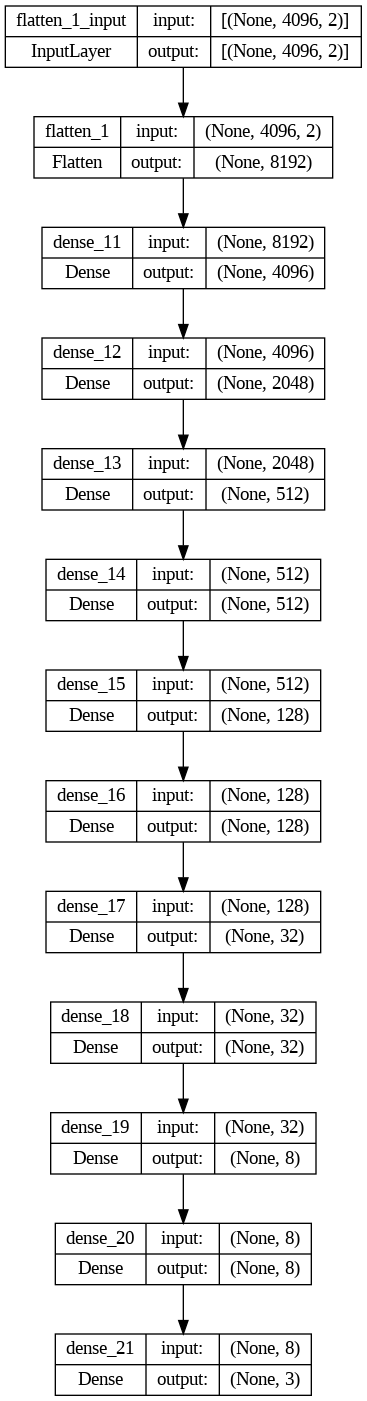

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
opt = tf.keras.optimizers.Adam(0.00005)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [13]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, y_train, epochs=7, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/7
441/441 [==============================] - 6s 13ms/step - loss: 0.6935 - accuracy: 0.7210 - val_loss: 0.4802 - val_accuracy: 0.8186
Epoch 2/7
441/441 [==============================] - 6s 13ms/step - loss: 0.4236 - accuracy: 0.8202 - val_loss: 0.4037 - val_accuracy: 0.8176
Epoch 3/7
441/441 [==============================] - 6s 14ms/step - loss: 0.3687 - accuracy: 0.8404 - val_loss: 0.3587 - val_accuracy: 0.8524
Epoch 4/7
441/441 [==============================] - 6s 13ms/step - loss: 0.3413 - accuracy: 0.8540 - val_loss: 0.4002 - val_accuracy: 0.8119
Epoch 5/7
441/441 [==============================] - 6s 13ms/step - loss: 0.3082 - accuracy: 0.8725 - val_loss: 0.3314 - val_accuracy: 0.8578
Epoch 6/7
441/441 [==============================] - 6s 13ms/step - loss: 0.2925 - accuracy: 0.8803 - val_loss: 0.3340 - val_accuracy: 0.8673
Epoch 7/7
441/441 [==============================] - 6s 13ms/step - loss: 0.2737 - accuracy: 0.8887 - val_loss: 0.3280 - val_accuracy: 0.8622


109/109 [==============================] - 1s 4ms/step


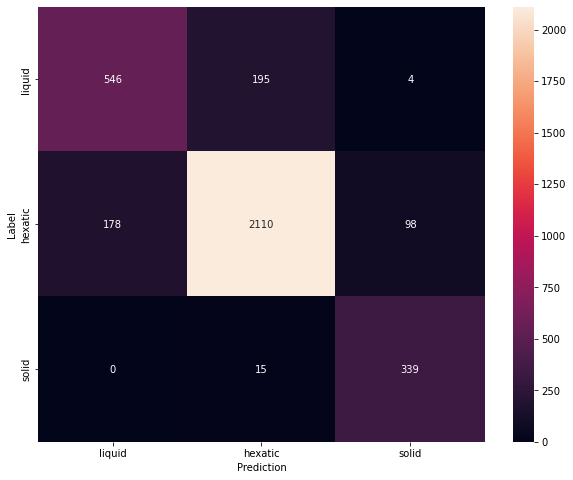

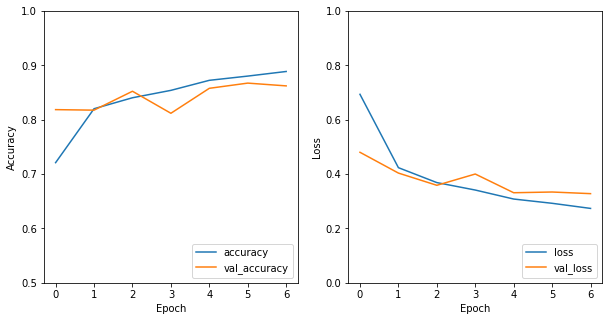

In [14]:
model.evaluate(X_test, y_test)
predictions = model.predict(X_test)
import seaborn as sns

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

confusion_mtx = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis=1))

show_confusion_matrix(confusion_mtx, ['liquid', 'hexatic', 'solid'])

# plot the time evolution of the accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history) 

# clear the session
tf.keras.backend.clear_session()

We reach an accuracy of $86\%$ on the test set. As one could see from the confusion matrix, the major source of error is between the liquid and hexatic phase. This could be normal because this kind of phase transition is of the first order, thus there is a coexistence between liquid phase and hexatic phase, and this could be hard to distinguish for the network. Moreover, my set is disbalanced, and an improvement in the future will surely be to have a more equilibrated training set. 

In [ ]:
# clear the session
tf.keras.backend.clear_session()